In [ ]:
# General scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
from scipy import signal
from scipy import fftpack
from scipy.constants import mu_0, epsilon_0
# Machine Epssilon for float
import ipywidgets
import time
import os
eps = np.finfo(float).eps

In [2]:
from masa_utils import PsuedoLog
from masa_utils import InducedPolarization
# FFT with various c

In [3]:
def plot_pelton(freq,res0=None, con8=None, eta=0.1, tau=1e-3, c=0.8, ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    if res0 is None and con8 is None:
        raise ValueError('Error: either res0 or con8 must be set')
    elif res0 is not None and con8 is not None:
        raise ValueError('Error: both sigma0 or sigmaInf are set')
    PL_pelton = PsuedoLog(
                logmin=1e-7,
                linScale=0.2,
                logminx=10.**np.floor(np.log10(freq[1])),
                linScalex=0.2)
    IPmodel_f = InducedPolarization(con8=con8, res0=res0, eta=eta, tau=tau, c=c)
    if con8 is None:
        fft_f = IPmodel_f.pelton_res_f(freq, res0, eta, tau, c)
        ax[0].set_title(f''' Resistivity form
            res0={res0:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
    if res0 is None:
        fft_f = IPmodel_f.pelton_con_f(freq, con8, eta, tau, c)
        ax[0].set_title(f''' Conductivity form
             con8={con8:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
    ax[0] = PL_pelton.semiplx(x=freq, y=fft_f.real, ax=ax[0], yscale_log=False,
                              label='Real', color="C0")
    ax[0] = PL_pelton.semiplx(x=freq, y=-fft_f.imag, ax=ax[0], yscale_log=False,
                              label='Imaginary', color="C1")
    ax[0] = PL_pelton.semiplx(x=freq, y=np.abs(fft_f), ax=ax[0], yscale_log=False,
                              label='Absolute Value', color="C2")
    PL_pelton.pl_axes_x(ax=ax[0])
    ax[1] = PL_pelton.semiplx(x=freq, y=np.degrees(np.angle(fft_f)), ax=ax[1], yscale_log=False,
                              label='Phase (degrees)', color="C0")
    PL_pelton.pl_axes_x(ax=ax[1])

   # Shared x-axis label and vertical line
    for a in ax:
        a = PL_pelton.pl_axvline(ax=a, x=1/tau,label=r'$1/\tau$')
#        a = PL_pelton.pl_axvline(ax=a, x=1/tau/2/np.pi,label=r'$1/\tau $')
        a.set_xlabel('Frequency [Hz]')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
    ax[1].set_ylabel('Phase [Degrees]')
    return ax 

In [4]:
res0min, res0max = 1.0e-3, 1.0e6
log10res0min, log10res0max = np.log10(res0min), np.log10(res0max)
con8min, con8max = 1.0e-6, 1.0e3
log10con8min, log10con8max = np.log10(con8min), np.log10(con8max)
etamin, etamax = 0, 0.99
taumin, taumax = 1.0e-6, 1.0
log10taumin, log10taumax = np.log10(taumin), np.log10(taumax)
cmin, cmax = 0., 1.0
res0_default, eta_default, tau_default, c_default = 200, 0.5,  0.1, 1.
con8_default = 1 / (res0_default * (1 - eta_default))


In [5]:
#  Widget for the main function
def plot_colecole_widget(conductivity_or_resistivity, res0=None, con8=None, eta=None, tau=None, c=None):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    nfreq = 2**16
    freqcen = 1/(tau)
    freqend = freqcen * nfreq**0.5
    freqstep = freqend/nfreq
    freq = np.arange(0,freqend,freqstep) 

    if conductivity_or_resistivity == "Resistivity":
        plot_pelton(freq=freq,res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    else:
        plot_pelton(freq=freq,con8=con8, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    plt.show()

# ToggleButtons for selecting resistivity or conductivity
conductivity_or_resistivity = ipywidgets.ToggleButtons(
    options=["Resistivity", "Conductivity"],
    description="Mode:",
    disabled=False,
    button_style='info',
)

# Define sliders
res0_slider = ipywidgets.FloatLogSlider(base=10, min=log10res0min, max=log10res0max, 
                                      value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(base=10, min=log10con8min, max=log10con8max, 
                                      value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                  value=eta_default, description="eta")
tau_slider = ipywidgets.FloatLogSlider(base=10, min=log10taumin, max=log10taumax, 
                                     value=tau_default, description="tau")
c_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                value=c_default, description="c")
# Use interactive display based on the toggle selection
def update_sliders(mode):
    if mode == "Resistivity":
        display(res0_slider, eta_slider, tau_slider, c_slider)
    else:
        display(con8_slider, eta_slider, tau_slider, c_slider)

ipywidgets.widgets.interactive_output(update_sliders, {'mode': conductivity_or_resistivity})
ipywidgets.widgets.interactive(
    plot_colecole_widget,
    conductivity_or_resistivity=conductivity_or_resistivity,
    res0=res0_slider,
    con8=con8_slider,
    eta=eta_slider,
    tau=tau_slider,
    c=c_slider,
)

interactive(children=(ToggleButtons(button_style='info', description='Mode:', options=('Resistivity', 'Conduct…

# FFT with various c

In [8]:
def plot_fft(con_form,res0=None, con8=None,log2nfreq=16, eta=0.1, tau=1e-3, c=0.8, ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax = plt.subplots(2,1, figsize=(8, 6))

    IPmodel_fft = InducedPolarization(con8=con8, res0=res0,eta=eta, tau=tau, c=c)
    freq_tau=IPmodel_fft.get_frequency_tau(log2nfreq=log2nfreq)
    times_tau, data_tau = IPmodel_fft.pelton_fft(con_form=con_form, freq=freq_tau)
    time_step = times_tau[1] - times_tau[0]
    data_tau *= time_step
    data_tau_intg = np.cumsum(data_tau)

    if con_form:
        ax[0].set_title(f'''Conductivity multiplied by time step {time_step:.2e}, ntimesetp {len(times_tau)}
        con8={con8:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
        ax[1].set_title('Conductivity Integrated over time')
    else:
        ax[0].set_title(f'''Resistivity multiplied by time step {time_step:.2e}, ntimesetp {len(times_tau)}
        res0={res0:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
        ax[1].set_title('Resistivity Integrated over time')

    # freq_tau_time =IPmodel_fft.get_frequency_tau_times(times=times_tau)
    # times_tau_time, data_tau_time = IPmodel_fft.pelton_fft(con_form=con_form, freq=freq_tau_time)
    # timestep = times_tau_time[1] - times_tau_time[0]
    # data_tau_time *= timestep
    # data_tau_time_intg = np.cumsum(data_tau_time)
    # IPmodel_fft.get_windows(times=times_tau)
    # window_mat = IPmodel_fft.get_window_matrix(times=times_tau_time)
    # window_data = window_mat@data_tau_time
    # window_data_intg = window_mat@data_tau_time_intg
    # time_step = times_tau[1] - times_tau[0]
    PL_fft = PsuedoLog(
                logmin=10.**np.floor(np.log10(data_tau[0])-3.),
                linScale=0.2,
                logminx=10.**np.ceil(np.log10(time_step)),
                linScalex=0.2)
    ax[0] = PL_fft.plpl_plot(x=np.r_[0,times_tau[0]], y=np.r_[0,data_tau[0]], ax=ax[0], 
                             label='t=0', color="C0",
                             marker='o', markersize=4) 
    ax[0] = PL_fft.plpl_plot(x=times_tau[1:], y=data_tau[1:], ax=ax[0], 
                                label='t>0', color="C0") 

    PL_fft.pl_axes(ax=ax[0])
    PL_fft.pl_axes_x(ax=ax[0])
    ax[1] = PL_fft.semiplx(x=times_tau, y=data_tau_intg, ax=ax[1], yscale_log=False,
                                label='More sampled', color="C0")
    PL_fft.pl_axes_x(ax=ax[1])
    ax[1].set_ylim(bottom=0)


    for a in ax:
        a = PL_fft.pl_axvline(ax=a, x=tau,label=r'$\tau$')
        a.set_xlabel('time(sec)')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
    return ax 

In [9]:
res0_default, eta_default, tau_default, c_default = 0.15, 0.3,  1e-3, 0.8
con8_default = 1 / (res0_default * (1 - eta_default))

In [10]:
#  Widget for the main function
def plot_fft_widget(conductivity_or_resistivity, res0=None, con8=None, eta=None, tau=None, c=None):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    log2nfreq = 11

    if conductivity_or_resistivity == "Resistivity":
        plot_fft(con_form=False,log2nfreq=log2nfreq,res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    else:
        plot_fft(con_form=True,log2nfreq=log2nfreq,con8=con8, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    plt.show()

# ToggleButtons for selecting resistivity or conductivity
conductivity_or_resistivity = ipywidgets.ToggleButtons(
    options=["Resistivity", "Conductivity"],
    description="Mode:",
    disabled=False,
    button_style='info',
    value= "Conductivity"
)

# Define sliders
res0_slider = ipywidgets.FloatLogSlider(base=10, min=log10res0min, max=log10res0max, 
                                      value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(base=10, min=log10con8min, max=log10con8max, 
                                      value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                  value=eta_default, description="eta")
tau_slider = ipywidgets.FloatLogSlider(base=10, min=log10taumin, max=log10taumax, 
                                     value=tau_default, description="tau")
c_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                value=c_default, description="c")
# Use interactive display based on the toggle selection
def update_sliders(mode):
    if mode == "Resistivity":
        display(res0_slider, eta_slider, tau_slider, c_slider)
    else:
        display(con8_slider, eta_slider, tau_slider, c_slider)

ipywidgets.widgets.interactive_output(update_sliders, {'mode': conductivity_or_resistivity})
ipywidgets.widgets.interactive(
    plot_fft_widget,
    conductivity_or_resistivity=conductivity_or_resistivity,
    res0=res0_slider,
    con8=con8_slider,
    eta=eta_slider,
    tau=tau_slider,
    c=c_slider,
)

interactive(children=(ToggleButtons(button_style='info', description='Mode:', index=1, options=('Resistivity',…

# Convolve with rectangular wave

In [11]:
res0, eta, tau, c = 0.15, 0.3,  1e-3, 0.8
con8 = 1/(res0*(1-eta))
IPmodel = InducedPolarization(con8=con8, res0=res0,eta=eta, tau=tau, c=c)

In [12]:
## Prepare function for waveform
def rect_wave(t, basefrq, neg=False):
    if neg:
        pos= 0.5*(1.0+signal.square(2*np.pi*(basefrq*t    ),duty=0.25))
        neg=-0.5*(1.0+signal.square(2*np.pi*(basefrq*t+0.5),duty=0.25))
        return pos + neg
    else :
        pos= 0.5*(1.0+signal.square(2*np.pi*(basefrq*t    ),duty=0.5))
        return pos


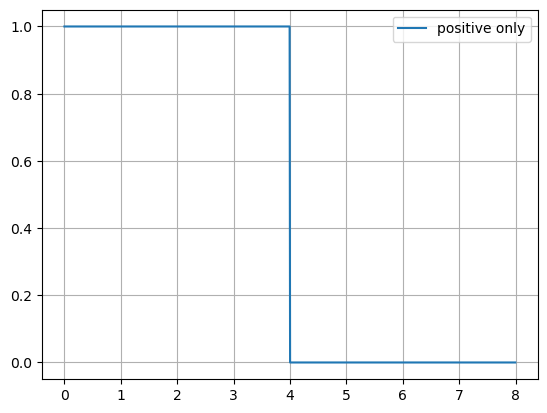

In [13]:
basefrq = 0.125
time_end = 1/basefrq
time_step = time_end/1000
times_smp = np.arange(0, time_end, time_step)
signal_smp = rect_wave(times_smp, basefrq)
plt.plot(times_smp,rect_wave(t=times_smp,basefrq=basefrq),label='positive only')
#plt.plot(times_smp,rect_wave(t=times_smp,basefrq=basefrq,neg=True),'--',label='Alternating')
plt.grid()
plt.legend()

In [14]:
def cnv_trans(basefrq, con_form=False,con8=con8, res0=None,eta=None, tau=None, c=None):
    baseperiod = 1/basefrq
    freq_tau=IPmodel.get_frequency_tau(tau=tau,log2nfreq=20)
    times_tau, data_tau = IPmodel.pelton_fft(con_form=con_form, freq=freq_tau,
            con8=con8,res0=res0,eta=eta,tau=tau, c=c)
    times_tau = times_tau[times_tau <= baseperiod]
    ntime = len(times_tau)
    time_step = times_tau[1] - times_tau[0]
    data_tau = data_tau[:ntime] *time_step
    signal_smp = rect_wave(t=times_tau, basefrq=basefrq)
    obs_smp = np.convolve(signal_smp, data_tau, mode='full')[:ntime]
    return times_tau, obs_smp

In [15]:
def cnv_trans_time(basefrq,time_smp, con_form=False, res0=None,con8=con8,eta=None, tau=None, c=None):
    freq_tau_time =IPmodel.get_frequency_tau_times(tau=tau, times=time_smp)
    times_tau_time, data_tau_time = IPmodel.pelton_fft(con_form=con_form
        , freq=freq_tau_time,con8=con8, res0=res0,eta=eta,tau=tau, c=c)
    time_step = times_tau_time[1] - times_tau_time[0]
    data_tau_time *= time_step
    ntime = len(times_tau_time)
    signal_smp = rect_wave(times_tau_time, basefrq)
    obs_smp = np.convolve(signal_smp, data_tau_time, mode='full')[:ntime]
    window_data = IPmodel.apply_windows(times=times_tau_time, data=obs_smp)
    return window_data #,times_tau_time, obs_smp

In [16]:
res0, eta, tau, c = 0.15, 0.3,  1e-4, 0.8
con8 = 1/(res0*(1-eta))
basefrq = 125 #bfrq_tau*tau*float(ntime)
print(f'basefrq:{basefrq:10.2f}')
time_obs, data_obs = cnv_trans(basefrq=basefrq,
        con_form=False,res0=res0, eta=eta, tau=tau, c=c)
print(len(time_obs), len(data_obs))
hlf = int(len(time_obs))//2
print(f'end   of on-time  res0 {data_obs[hlf-1]:10.2e}')
print(f'start of off-time res8 {data_obs[hlf+1]:10.2e}')
print(f'eta calculated         {(data_obs[hlf+1]/data_obs[hlf-1]):10.2e}')
print(f'eta given              {eta:10.2e}')

basefrq:    125.00
log2(len(freq)) 20.0 considering tau
81921 81921
end   of on-time  res0   1.49e-01
start of off-time res8   4.41e-02
eta calculated           2.95e-01
eta given                3.00e-01


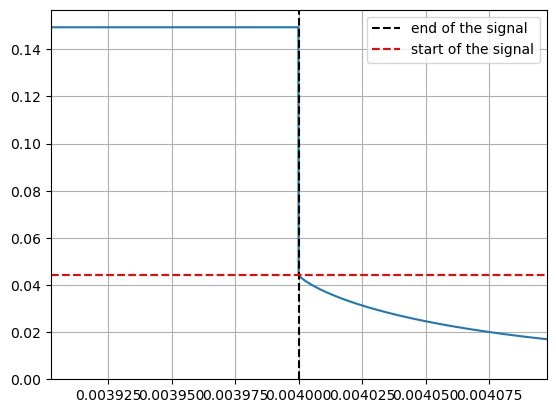

In [17]:
plt.plot(time_obs, data_obs)
plt.axvline(0.5/basefrq, color='k', linestyle='--', label='end of the signal')
plt.axhline(data_obs[-hlf], color='r', linestyle='--', label='start of the signal')
nxzoom = 1000
plt.xlim([time_obs[hlf-nxzoom],time_obs[-hlf+nxzoom]])
plt.ylim(bottom=0)
plt.grid()
plt.legend()

In [18]:
def plot_dcip(basefrq,nxzoom=100,con_form=False
        ,con8=None,res0=None,eta=None,tau=None,c=None,ax=None):
    if ax is None:
        fig, ax = plt.subplots(2,1, figsize=(8, 6))
    time_obs, data_obs = cnv_trans(basefrq=basefrq,
        con_form=con_form,con8=con8,res0=res0, eta=eta, tau=tau, c=c)
    hlf = int(len(time_obs))//2
    eta_est = data_obs[hlf+1]/data_obs[hlf-1]
    ntime = len(time_obs)
    ax[0].plot(time_obs, data_obs)
    ax[0].set_title(f'''res0={res0   :10.2e},eta given={eta    :8.3f},  tau={tau:10.2e}, c={c:8.3f}
    bfrq={basefrq:10.2f},eta est  ={eta_est:8.3f},ntime={ntime:8.0f},zoom={nxzoom:8.0f}''')         
    ind_plot = slice(hlf-nxzoom,hlf+nxzoom)
    ax[1].plot(time_obs[ind_plot], data_obs[ind_plot])
    for a in ax:
        a.axvline(0.5/basefrq, color='k', linestyle='--', label='on time end')
        a.axhline(data_obs[-hlf], color='r', linestyle='--', label='amp at start start of decay')
        a.set_ylim(bottom=0)
        a.grid()
        a.legend()

In [19]:
log10bfrqmin, log10bfrqmax = -1, 2
res0_default, eta_default, tau_default, c_default = 0.15, 0.3, 1e-3, 0.8
con8_default = 1 / (res0_default * (1 - eta_default))
basefrq_default = int(1/(tau_default))

In [20]:
#  Widget for the main function
def plot_dcip_widget(basefrq,nxzoom, res0=None, con8=None, eta=None, tau=None, c=None):
    # Use default values if not provided
    res0 = res0 if res0 is not None else res0_default
    con8 = con8 if con8 is not None else con8_default
    eta = eta if eta is not None else eta_default
    tau = tau if tau is not None else tau_default
    c = c if c is not None else c_default
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    plot_dcip(basefrq=basefrq,nxzoom=nxzoom, con_form=False,res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    plt.show()

basefrq_slider = ipywidgets.IntSlider(base=10, min=log10bfrqmin, max=log10bfrqmax,
                                        value=basefrq_default, description="Base Frequency")
basefrq_slider = ipywidgets.FloatLogSlider(base=10, min=log10bfrqmin, max=log10bfrqmax, 
                                        value=basefrq_default, description="Base Frequency")
res0_slider = ipywidgets.FloatLogSlider(base=10, min=log10res0min, max=log10res0max, 
                                      value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(base=10, min=log10con8min, max=log10con8max, 
                                      value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                  value=eta_default, description="eta")
tau_slider = ipywidgets.FloatLogSlider(base=10, min=log10taumin, max=log10taumax, 
                                     value=tau_default, description="tau")
c_slider = ipywidgets.FloatSlider(min=0, max=1, step=0.01, 
                                value=c_default, description="c")
nxzoom_slider = ipywidgets.IntSlider(min=10, max=1000, step=10, 
                                  value=100, description="Zoom")

interactive_output_widget = ipywidgets.interactive_output(
    plot_dcip_widget,
    {
        "basefrq": basefrq_slider,
        "res0": res0_slider,
        "con8": con8_slider,
        "eta": eta_slider,
        "tau": tau_slider,
        "c": c_slider,
        "nxzoom": nxzoom_slider,
    }
)
# Display sliders and output
ui = ipywidgets.VBox([
    basefrq_slider, 
    res0_slider, 
    con8_slider, 
    eta_slider, 
    tau_slider, 
    c_slider, 
    nxzoom_slider
])
display(ui, interactive_output_widget)

Output()